# Initial setups

## Imports and structs

In [1]:
using JuMP
using Gurobi
env = Gurobi.Env()
using PowerSystems

using CSV

using Graphs
using MetaGraphsNext
using CairoMakie
using GraphMakie
using SparseArrays
using GraphMakie.NetworkLayout

import LaTeXStrings

CairoMakie.activate!(type = "svg")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-27


In [2]:
mutable struct Branch
    b::Float64
    p_max::Float64
    v_nom1::Float64
    v_nom2::Float64
    p::Float64
    outage::Bool
    trip::Bool
    Branch(b, p_max) = new(b, p_max, 0, 0, 0, false, false)
    Branch(b, p_max, v_nom1, v_nom2) = new(b, p_max, v_nom1, v_nom2, 0, false, false)
    Branch(b::Branch) = new(b.b, b.p_max, b.v_nom1, b.v_nom2, b.p, false, false)
    Branch(b::Branch, p_max) = new(b.b, p_max, b.v_nom1, b.v_nom2, b.p, false, false)
end

struct BranchId
    bus1::Int64
    bus2::Int64
end

In [3]:
mutable struct SubBus
    p::Float64
    branch_ids::Vector{Int8}
end

mutable struct BusConf
    bus::Int16
    subBuses::Vector{SubBus}
end

## Utility functions

## Graph

In [4]:
e_index_for(g::MetaGraph, e::Graphs.SimpleEdge) = g[label_for(g,src(e)), label_for(g,dst(e))]

e_index_for (generic function with 1 method)

In [358]:
function add_subBus(g::MetaGraph, busconfs::Vector{BusConf})
    h=deepcopy(g)
    e_labels = collect(edge_labels(h))
    for bc in busconfs
        bc_bus_label = label_for(g, bc.bus)
        # Map the branches of the subBus
        sb2edges = Dict(sb => [e_labels[br] for br in sb.branch_ids] for sb in bc.subBuses)
        edges_origin = collect(edges(h))
        edges_to_remove = [edges_origin[br] for sb in bc.subBuses for br in sb.branch_ids]
        for e in edges_to_remove
            rem_edge!(h, src(e), dst(e))
        end

        # Build the new bus and connect the branches
        for (i, sb) in enumerate(bc.subBuses)
            #create the new vertex
            new_v_label = "$(bc_bus_label)-$i"
            h[new_v_label] = sb.p
            h[bc_bus_label] = h[bc_bus_label] - sb.p
            # connect the copy of the branches
            for br in sb2edges[sb]
                new_e_label = br[1] == bc_bus_label ? (new_v_label, br[2]) : (br[1], new_v_label)
                h[new_e_label...] = g[br...]
            end
        end
    end
    h
end

function add_subBus(edge_ids::Union{Int, Vector{Int}}, g, busconfs::Vector{BusConf})
    edge_moved_to_end = [br for bc in busconfs for sb in bc.subBuses for br in sb.branch_ids]
    
    function a_sb(e_id)
        ff = findfirst(isequal(e_id), edge_moved_to_end)
        if isnothing(ff)
            return e_id - length([br for bc in busconfs for sb in bc.subBuses for br in sb.branch_ids if br ≤ e_id])
        else
            return ne(g) - length(edge_moved_to_end) + ff
        end
    end

    if isa(edge_ids, Int)
        return a_sb(edge_ids)
    end

    res_edge_ids = copy(edge_ids)
    foreach(((i,e_id),) ->res_edge_ids[i] = a_sb(e_id), enumerate(res_edge_ids))
    return res_edge_ids
end

function add_subBus(g::MetaGraph, busconfs::Vector{BusConf}, edge_ids::Vector{Int})
    add_subBus(g, busconfs), add_subBus(edge_ids,g, busconfs)
end

function add_subBus(g::MetaGraph, busconfs::Vector{BusConf}, edge_ids::Vector{Int}, id::Int)
    add_subBus(g, busconfs), add_subBus(edge_ids, g, busconfs), add_subBus(id, g, busconfs)
end


add_subBus (generic function with 6 methods)

In [288]:
display(bus_confs)
collect(enumerate(edge_labels(g)))

1-element Vector{BusConf}:
 BusConf(6, SubBus[SubBus(-0.17, Int8[7, 9])])

20-element Vector{Tuple{Int64, Tuple{String, String}}}:
 (1, ("5", "6"))
 (2, ("6", "12"))
 (3, ("6", "11"))
 (4, ("6", "13"))
 (5, ("12", "13"))
 (6, ("10", "11"))
 (7, ("2", "5"))
 (8, ("2", "3"))
 (9, ("2", "4"))
 (10, ("9", "14"))
 (11, ("9", "10"))
 (12, ("3", "4"))
 (13, ("4", "5"))
 (14, ("4", "9"))
 (15, ("4", "7"))
 (16, ("13", "14"))
 (17, ("1", "5"))
 (18, ("1", "2"))
 (19, ("7", "9"))
 (20, ("7", "8"))

In [355]:

println(list)
println(add_subBus(list, g, bus_confs))

[6, 19, 7, 20, 13]
[6, 17, 19, 18, 11]


### Minigrid

In [6]:
function build_simple_grid(;micro = true)
    g = MetaGraph(
        DiGraph();
        label_type=String,
        vertex_data_type = Float64,
        edge_data_type = Branch,
    )
    g["1"] = micro ? -2 : -3
    for i=2:(micro ? 3 : 4)
        g["$i"] = 1
    end
    g["1","2"] = Branch(1, 1)
    g["2","3"] = Branch(1, 1)
    if micro
        g["1","3"] = Branch(1,1)
    else
        g["3","4"] = Branch(1, 1)
        g["2","4"] = Branch(1, 1)
        g["1","4"] = Branch(1, 1)
    end
    g
end


build_simple_grid (generic function with 1 method)

### Parse MatPower files

In [7]:
function network2graph(sys::System, v=false)
    g = MetaGraph(
        DiGraph();
        label_type=String,
        vertex_data_type = Float64,
        edge_data_type = Branch,
    )

    init_p_bus(g, sys, objType, op) = 
        for k in get_components(objType, sys)
            v && println("bus $(k.bus.number)\t$(repr(op)) $(k.active_power)")
            g["$(k.bus.number)"] = op(haskey(g,"$(k.bus.number)") ? g["$(k.bus.number)"] : 0, k.active_power)
        end
    init_p_bus(g, sys, PowerLoad, +)
    init_p_bus(g, sys, Generator, -)
    
    v && println("branches")
    for k in get_components(ACBranch, sys)
        if !haskey(g, "$(k.arc.from.number)")
            v && println("bus: $(k.arc.from.number)")
            g["$(k.arc.from.number)"] = 0
        end
        if !haskey(g, "$(k.arc.to.number)")
            v && println("bus: $(k.arc.to.number)")
            g["$(k.arc.to.number)"] = 0
        end
        v && println("(\"$(k.arc.from.number)\", \"$(k.arc.to.number)\") ")
        g["$(k.arc.from.number)", "$(k.arc.to.number)"] = Branch(1/k.x, 10, k.arc.from.base_voltage, k.arc.to.base_voltage)
    end
    
    to_remove = []
    for node in vertices(g)
        if isempty(inneighbors(g,node)) && isempty(outneighbors(g,node))
            push!(to_remove, label_for(g,node))
        end
    end
    v && !isempty(to_remove) && println("\nremove nodes: $to_remove")

    foreach(node-> rem_vertex!(g, code_for(g,node)), to_remove)
    
    g
end

network2graph (generic function with 2 methods)

In [8]:
function balance!(g)
    non_zeros = [label for label in labels(g) if g[label] ≠ 0]
    imbalance = sum(g[label] for label in non_zeros) / length(non_zeros)
    for label in non_zeros
        g[label] -= imbalance
    end
end

balance! (generic function with 1 method)

In [9]:
function check_flow_consistency(g; v::Bool=false)
    flows = Dict(l => g[l...].p for l in edge_labels(g))
    injections = Dict(l => g[l] for l in labels(g))

    # Initialize net flows for each node
    net_flows = Dict{String, Float64}()

    # Update net flows based on branch flows
    for ((from, to), flow) in flows
        net_flows[from] = get(net_flows, from, 0.0) - flow
        net_flows[to] = get(net_flows, to, 0.0) + flow
    end

    # Compare with injections
    consistent = true

    v && println("\nComparison with injections:")
    for (node, injection) in injections
        net_flow = get(net_flows, node, 0.0)

        v && println("Node $node: Injection = $injection, Net Flow = $net_flow, Difference = $(injection - net_flow)")
        if abs(injection - net_flow) > 1e-9  # Tolerance for floating-point comparison
            consistent = false
        end
    end

    if v
        if consistent
            println("\nThe flows and injections are consistent.")
        else
            println("\nThe flows and injections are not consistent.")
        end
    end
    consistent
end

check_flow_consistency (generic function with 1 method)

### Tune the grid with constraints - indicators on OTS results

In [10]:
add_constraint(g, fun) = foreach(e -> fun(e_index_for(g,e)), edges(g))

set_limitations(branches, lim) = Dict( k => begin
        br_out = Branch(br_in, br_in.v_nom1 == 138.0 ? lim : 10)
    end for (k,br_in) in branches)

function indicators(model)
    sw = [s for s in model[:sw] if value(s) == 0.0]
    ls = [l for l in model[:ls] if value(l) ≠ 0.0]
    sw, ls
end

indicators (generic function with 1 method)

### LaTeX

In [11]:
function filter_latex_formulation(model, word)
    lf = repr(latex_formulation(model))
    word == "" && return LaTeXStrings.LaTeXString(lf)
    splited = split(lf ,"\n")
    filtered = join(filter(line-> occursin(word, line), splited), "\n")
    joined = join(["\\begin{aligned}", filtered
                , "\\end{aligned}"], " ")
    LaTeXStrings.LaTeXString(joined)
end

filter_latex_formulation (generic function with 1 method)

### Get results

In [12]:
function store_result(model, filename)
    open(filename, "w") do file
        foreach(k->println(file, "$k, $(value(k))"), all_variables(model))
    end
end

store_result (generic function with 1 method)

## Drawing

In [13]:
"""
    generate_csv(Dict{String, Point2}) -> String
    
Generates a String that represents a CSV file from the dict of Points
"""
function generate_csv(dic)
    println("bus_i,x,y")
    foreach(l->println("$l, $(dic[l][1]), $(dic[l][2])"), sort(collect(keys(dic)), by=x-> parse(Int, x)))
end

generate_csv

In [14]:
"""
    load_coord(filename) -> Dict{String, Point2}

Load a csv file containing the coordinates
"""
function load_coord(file)
    csv_data = CSV.File(file)
    coord = Dict{String, Point2}()
    foreach(row -> coord["$(row.bus_i)"] = Point(row.x, row.y), csv_data)
    coord
end

load_coord

In [15]:
function complete_subBus_coords(g, init_points)
    res_points = Point2[]
    for lab in labels(g)
        if haskey(init_points, lab)
            push!(res_points, init_points[lab])
        else
            neighbs = [label_for(g, c) for c in all_neighbors(g, code_for(g, lab))]
            push!(neighbs, split(lab, "-")[1])
            push!(res_points, 1/length(neighbs) * reduce(+, [init_points[lab] for lab in neighbs]))
        end
    end
    res_points
end

complete_subBus_coords (generic function with 1 method)

In [16]:
function draw(g_orig::MetaGraph;

                outages = [],
                trip = nothing,
    
                fig_size = (900, 600),
                font_size = 15,
                layout = Stress(Ptype=Float32),
                margin_ratio =7,
                digits = 2,
    
                node_label = (g, label; digits = 2) -> "$label($(round(g[label], digits=digits)))",
                marker = (g, label) -> g[label]>=0 ? :rect : :circle,
                node_size = (g, label, max_p) -> sqrt(abs(g[label]))/sqrt(max_p)*80,

                edge_labels = (br; digits = 2) -> repr(round(br.p, digits=digits)),
                edge_coloring = (br; tol=1e-6) -> br.outage ? :black : (abs(br.p>br.p_max + tol) ? :red : :green),
                edge_style = branch -> branch.trip ? :dot : :solid,
                edge_width = 3,
                arrow_size = 25,
                )

    g = copy(g_orig)
    max_p = maximum(collect(labels(g)) .|> l->abs(g[l]))
    gLabels = [label_for(g, v) for v in vertices(g)]
    to_reverse = []
    for (i,e) in enumerate(edges(g))
        br = e_index_for(g, e)
        if i in outages
            br.outage = true
        end
        if i == trip
            br.trip = true
        end
        if br.p<0
            push!(to_reverse, e)
        end
    end
    for e in to_reverse
        b = e_index_for(g, e)
        b.p = -b.p
        rem_edge!(g, src(e), dst(e))
        g[label_for(g,dst(e)), label_for(g,src(e))] = b
    end

    fig = Figure(size = fig_size, fontsize = font_size)
    ax = Axis(fig[1, 1])

    x_min, x_max, y_min, y_max = reduce(((x_min, x_max, y_min, y_max), pt) 
        -> (min(pt[1], x_min), max(pt[1], x_max), min(pt[2], y_min), max(pt[2], y_max)), 
        layout isa Dict{String, Point2} ? values(layout) : layout(g) , init = (0,0,0,0))
    delta_x, delta_y = ((x_max - x_min) , (y_max - y_min)) ./ margin_ratio
    xlims!(ax, x_min-delta_x, x_max+delta_x)
    ylims!(ax, y_min-delta_y, y_max+delta_y)
    
    g_labels = [label_for(g, v) for v in vertices(g)]
    branches = [e_index_for(g, e) for e in edges(g)]

    graphplot!(ax, g;
        layout = layout isa Dict{String, Point2} ? complete_subBus_coords(g, layout) : layout,
        node_size = [node_size(g, l, max_p) for l in gLabels],
        node_attr = (marker = [marker(g, l) for l in g_labels], color= :white, strokecolor = :red, strokewidth = 3,),
        nlabels = [node_label(g, l, digits=digits) for l in g_labels],
        elabels = [edge_labels(b, digits=digits) for b in branches],
        edge_plottype = :beziersegments,
		edge_attr = (linestyle = [edge_style(b) for b in branches],),
        edge_color = [edge_coloring(b) for b in branches],
        edge_width = edge_width,
        arrow_size = arrow_size,
        arrow_shift = :end,
        )
    hidedecorations!(ax)
    hidespines!(ax)

    ax.aspect = DataAspect()
    display(fig)
    fig
end

draw (generic function with 1 method)

# Models

## DC-PF with linear algebra

In [17]:
function dc_flow!(g; outages = [], trip = nothing)
    A = incidence_matrix(g; oriented = true)'
    for outage in outages
        A[outage,:] .= 0
    end
    if trip ≠ nothing
        A[trip,:] .= 0
    end
    D = spdiagm([e_index_for(g,e).b for e in edges(g)])
    B = A'*D*A
    B_inv = inv(Matrix(B + fill(1/nv(g), nv(g), nv(g)))) - fill(1/nv(g), nv(g), nv(g))
    
    p_to_f = D*A*B_inv
    flows = p_to_f * [g[label_for(g, v)] for v in vertices(g)]
    for (i,e) in enumerate(edges(g))
        e_index_for(g, e).p = flows[i]
    end
    g
end

function dc_flow(g; outages = [], trip = nothing)
    h=deepcopy(g)
    dc_flow!(h, outages = outages, trip = trip)
end


dc_flow (generic function with 1 method)

## Secured DC OTS

With $\mathcal{C}$ the set of contingencies, $\mathcal{V}$ the set of edges and $\mathcal{E}$ the set of edges.

$$
\begin{split}
    \rho^* = \arg\,\min_{\pmb{\gamma},\vec{v}, \pmb{\beta}, \pmb{f}, \rho}\, & \rho +\alpha \sum_{e \in \mathcal{E}}{v_e}\\
    s.t.\\
    \vec{f_c} = \pmb{DA\hat{B}^{-1}} \vec{p} + (\pmb{D - DA\hat{B}^{-1}A^TD})(\vec{\beta_c} + \vec{\gamma_c}) & \quad \forall c \in \mathcal{C} \\
    |\vec{f_c}| \preceq \rho \overline{\vec{f_c}} & \quad \forall c \in \mathcal{C} \\
    (1-\vec{v}) \odot \vec{\gamma_c} = 0 & \quad \forall c \in \mathcal{C} \\
    \beta_{c, e} = 0 & \quad \forall (c,e) \in \mathcal{C}\times\mathcal{E}\ |\ c\ne e \\
    v_{e} \in \{0,1\} & \quad \forall e \in \mathcal{E} \\
\end{split}
$$

The cost function is the weighted sum of the maximum overload and the sum of line openings. The later term reduces the number of line openings, the weight $\alpha$ can be pretty low so that it does not impede the main cost.

A lower bound can be set on the overload so that $\rho \ge \rho\_min\_bound$ (the default value is 0). Thus, when a line is below this bound, no measure is to be taken. A bound set to 1 implies the operational limits are targeted.

A variant of the first term ($is\_single\_\rho = false$) consists in minimizing the sum of $\rho_e - \rho\_min\_bound \, \forall e \in \mathcal{E}$ over all the line. This allows to not only focus on the most loaded line, but to takes into account all the line above the threshold. 

Ensuring connectedness using a fictitious mirror graph with variables $\star$, having with the same switching and 1 source bus is injecting $|\mathcal{V}| - 1$ (no unit as it is fictitious injection), and each of the others is withdrawing $1$, which ensures there is a connected path from any of them to the source bus. This is done for all the contingencies. 

$$
\begin{split}
\overrightarrow{f^\star_{c}} \odot (1-\overrightarrow{u_c}) = 0 & \quad \forall c \in \mathcal{C} \\
\overrightarrow{f^\star_{c}} \odot (1-\overrightarrow{v}) = 0 & \quad \forall c \in \mathcal{C} \\
(f^\star_{c, e} - \phi^\star_{c, dst(e)} - \phi^\star_{c, src(e)}) * u_{c,e} = 0 & \quad \forall (c,e) \in \mathcal{C}\times\mathcal{E} \\
(f^\star_{c, e} - \phi^\star_{c, dst(e)} - \phi^\star_{c, src(e)}) * v_e = 0 & \quad \forall (c,e) \in \mathcal{C}\times\mathcal{E} \\
p^\star_i = \sum_{e \in \mathcal{E}|dst(e)=i}{f^\star_{c,e}} - \sum_{e \in \mathcal{E}|src(e)=i}{f^\star_{c,e}}  & \quad \forall (c, i) \in \mathcal{C}\times\{1..|\mathcal{V}|\} \\
p^\star_i  = 1 & \quad \forall i \in \{1..|\mathcal{V}| - 1\} \\
p^\star_n = - (|\mathcal{V}| - 1) \\
\end{split}
$$

Which translates into:
$$
\begin{split}
|\overrightarrow{f^\star_{c}}| \le M * (1-\overrightarrow{u_c}) & \quad \forall c \in \mathcal{C} \\
|\overrightarrow{f^\star_{c}}| \le M * (1-\overrightarrow{v}) & \quad \forall c \in \mathcal{C} \\
|f^\star_{c, e} - \phi^\star_{c, dst(e)} - \phi^\star_{c, src(e)}|  \le M * u_{c,e} & \quad \forall (c,e) \in \mathcal{C}\times\mathcal{E} \\
|f^\star_{c, e} - \phi^\star_{c, dst(e)} - \phi^\star_{c, src(e)}|  \le M * v_e & \quad \forall (c,e) \in \mathcal{C}\times\mathcal{E} \\
p^\star_i = \sum_{e|dst(e)=i}{f^\star_{c,e}} - \sum_{e|src(e)=i}{f^\star_{c,e}}  & \quad \forall (c, i) \in \mathcal{C}\times\{1..|\mathcal{V}|\} \\
p^\star_i  = 1 & \quad \forall i \in \{1..|\mathcal{V}| - 1\} \\
p^\star_n = - (|\mathcal{V}| - 1) \\
\end{split}
$$

A void contingency is added to take the base case into consideration, and the parameter $n\_1\_connectedness$ ($true$ by default)can be set to $false$ if the connectedness is not to be considered in N-1.

## DC_matrices

In [18]:
function create_dc_matrix(g)
    A = incidence_matrix(g; oriented = true)'
    D = spdiagm([e_index_for(g,e).b for e in edges(g)])
    B = A'*D*A
    B_inv = inv(Matrix(B + fill(1/nv(g), nv(g), nv(g))))
    p_to_f = D*A*B_inv
    δ_to_f = D - p_to_f*A'*D
    A, D, B_inv, p_to_f, δ_to_f
end

create_dc_matrix (generic function with 1 method)

## Flows

In [205]:
function flows_def!(model, big_M)

    g, A, nb_cases, allow_branch_openings, bus_confs, nb_bus_confs, outages, is_outage, p = (model.ext[k]
        for k in [:g, :A, :nb_cases, :allow_branch_openings, :bus_confs, :nb_bus_confs, :outages, :is_outage, :p])
    
    allow_branch_openings &&  (v_branch = model[:v_branch])
    gen = model[:gen]
    load = model[:load]
    
    cases = 1:nb_cases
    n_1cases = 1:nb_cases-1
    edge_ids = 1:ne(g)

    big_M=5

    @variable(model, flows[cases, 1:ne(g)])

    if allow_branch_openings
        @variable(model, γ_branch[1:nb_cases, 1:ne(g)])

        @constraint(model, [c in cases],  γ_branch[c, :] .≤ v_branch .* big_M)
        @constraint(model, [c in cases], -γ_branch[c, :] .≤ v_branch .* big_M)

        @constraint(model, [c in cases],  flows[c,:] .≤ (1 .- v_branch) .* big_M)
        @constraint(model, [c in cases], -flows[c,:] .≤ (1 .- v_branch) .* big_M)
    end

    @variable(model, v_bus[1:nb_bus_confs], Bin)
    @variable(model, γ_bus[1:nb_cases, k=1:nb_bus_confs])

    @constraint(model, [c in cases, 1:nb_bus_confs],  γ_bus[c, :] .≤ v_bus[:] .* big_M)
    @constraint(model, [c in cases, 1:nb_bus_confs], -γ_bus[c, :] .≤ v_bus[:] .* big_M)

    @variable(model, -big_M .≤ β[n_1cases] .≤ big_M)
    @constraint(model, [c in n_1cases], flows[c, outages[c]] == 0)  # nb_cases is the index of the base case

    D = spdiagm([e_index_for(g,e).b for e in edges(g)])
    B = A'*D*A
    N = nv(g)
    B_inv = inv(Matrix(B + fill(1/N, N, N))) - fill(1/N, N, N)
    p_to_f = D*A*B_inv
    δ_to_f = D - p_to_f*A'*D

    for c in cases
        outage_phase = @expression(model, c == nb_cases ? 0 : β[c] .* [is_outage(c,e) for e in edge_ids])
        line_opening_phase = @expression(model, allow_branch_openings ? γ_branch[c,:] : zeros(1:ne(g)))
        bus_splitting_phase = @expression(model, isempty(bus_confs) ? 0
            : [sum(br in sb.branch_ids ? (A[br, bus_confs[k].bus] * γ_bus[c, k]) : 0
                    for k=1:nb_bus_confs for sb in bus_confs[k].subBuses) for br = 1:ne(g)])

        @constraint(model,flows[c,:] .== p_to_f * (gen[c,:] .+ load[c,:]) 
                            + δ_to_f * (outage_phase .+ line_opening_phase .+ bus_splitting_phase))
    end

    for (k, bus, sb) in ((k, bc.bus, sb) for (k, bc) in enumerate(bus_confs) for sb in bc.subBuses)
        @constraint(model, [c in cases],
          sum(flows[c, br] * A[br, bus] for br in sb.branch_ids) - sb.p  ≤ (1 - v_bus[k]) * big_M)
        @constraint(model, [c in cases], 
        -(sum(flows[c, br] * A[br, bus] for br in sb.branch_ids) - sb.p) ≤ (1 - v_bus[k]) * big_M)
    end

    #TODO: add and test @constraint(model, [c in cases, bus in keys(bus_to_conf_idss)], sum(bc) ≤ 1 for bc in bus_to_conf_ids[bus]) ie pas plus d'une conf par poste. Et il faut aussi des confs avec plus d'un 2e bus.

end

flows_def! (generic function with 1 method)

## Overload

In [20]:
"""
    overload_def!(model,
                        g::MetaGraph,
                        nb_cases::Int,
                        is_single_ρ::Bool,
                        ρ_min_bound::Float64)

overload is the value to be minimized. It relies on ρ which is flow/flow_limit - ρ_min_bound. ρ_min_bound=1 if the expectation is to get a situation without overload. It can be either the max of load over all the branches (is_single_ρ) or it can be the sum of the of all the over the min_bound load.
"""
function overload_def!(model)

    g, is_single_ρ, ρ_min_bound, nb_cases = (model.ext[k] for k in [:g, :is_single_ρ, :ρ_min_bound, :nb_cases])
    flows = model[:flows]

    @variable(model, overload)
    p_max = [e_index_for(g, br).p_max for br in edges(g)]
    if is_single_ρ
        @variable(model, ρ ≥ ρ_min_bound)
        @constraint(model, overload == ρ - ρ_min_bound)
    
        @constraint(model, [i=1:nb_cases], flows[i,:] .≤ ρ.*p_max)
        @constraint(model, [i=1:nb_cases], -ρ.*p_max  .≤ flows[i,:])
    else
        @variable(model, ρ[1:ne(g)] ≥ 0)
        @constraint(model, overload == sum(ρ))
    
        @constraint(model, [i=nb_cases], flows[i,:] .≤ (ρ .+ ρ_min_bound).*p_max)
        @constraint(model, [i=nb_cases], -(ρ .+ ρ_min_bound).*p_max .≤ flows[i,:])
    end
    overload
end

overload_def!

## C_W

In [21]:
function c_w_def!(model)
    g, nb_cases, outages, is_outage = (model.ext[k] for k in [:g, :nb_cases, :outages, :is_outage])

    # c_w = max(is_outage, v_branch) == 1 if the corresponding branch is not connected to the base bus either by outage or line opening or bus splitting, ie c_w is ≤ 1, ≥ each of them, and ≤ the sum of them.
    
    cases = 1:nb_cases
    edges = 1:ne(g)
    @variable(model, c_w[cases, edges])
    if haskey(model, :v_branch)
        v_branch = model[:v_branch]
        @constraint(model, [c in cases, e in edges], c_w[c, e] ≥ is_outage(c,e))
        @constraint(model, [c in cases, e in edges], c_w[c, e] ≥ v_branch[e])
        @constraint(model, [c in cases, e in edges], c_w[c, e] ≤ is_outage(c,e) + v_branch[e])
    else
        @constraint(model, [c in cases, e in edges], c_w[c, e] == is_outage(c,e))
    end
end

c_w_def! (generic function with 1 method)

## Base connectedness and light

In [22]:
function base_connectedness!(model)

    g, bus_to_conf_ids, n_1_connectedness, bus_confs, nb_cases, A, bus_to_conf_ids, branch_to_conf_ids, branch_bus2side, branch_side2bus = (model.ext[bc_id] for bc_id in 
        [:g, :bus_to_conf_ids, :n_1_connectedness, :bus_confs, :nb_cases, :A, :bus_to_conf_ids, :branch_to_conf_ids, :branch_bus2side, :branch_side2bus])
    
    v_bus = model[:v_bus]
    # connectivity constraints
    nb_bus_tot = nv(g) + sum(length(bus_to_conf_ids[bus]) for bus in 1:nv(g))
    big_M2 = nb_bus_tot
    cases = (n_1_connectedness ? 1 : nb_cases):nb_cases        # nb_cases is the index of the base case
    edges = 1:ne(g)
    sides = 1:2
    buses = 1:nv(g)
    bus_confs_ids = 1:length(bus_confs)

    c_w = model[:c_w]

    # c_φ corresponds to the phase angle for source (1) and destination (2) of edges
    # c_Φ_base corresponds to the phase of the bus in the case all lines of the substation are connected
    @variable(model, c_φ[cases, edges, sides])
    @variable(model, c_flows[cases, edges])
    @variable(model, c_Φ_base[cases, buses])
    @variable(model, c_Φ_split[cases, bus_confs_ids])
    
    # the flow in the branch equals the angle difference between the terminals
    @constraint(model, [c in cases, e in edges], c_flows[c,e] == c_φ[c,e,2] - c_φ[c,e,1])
    
    # when a bus split is activated, then, the bus angle of the branch corresponds to the one of the new bus
    for (bc_id, bus, br) in [(bc_id, bc.bus, br) for (bc_id, bc) in enumerate(bus_confs) 
                                                    for sb in bc.subBuses for br in sb.branch_ids]
        side = branch_bus2side(br, bus)
        @constraint(model, [cases],   c_φ[:, br, side] .- c_Φ_split[:, bc_id]  .≤ big_M2 * (1 - v_bus[bc_id]))
        @constraint(model, [cases], -(c_φ[:, br, side] .- c_Φ_split[:, bc_id]) .≤ big_M2 * (1 - v_bus[bc_id]))
    end

    # terminal and bus angles are identical when the line is connected to the bus, which is the case when c_w==0 but not the case when the bus is split
    for c in cases, br in edges, s in sides
        is_a_conf_activated_on_bus = sum([v_bus[bc_id] for bc_id in filter(
                        conf_id -> branch_bus2side(br, bus_confs[conf_id].bus) == s,
                        branch_to_conf_ids[br])])
        @constraint(model, c_φ[c, br, s] - c_Φ_base[c, branch_side2bus(br, s)]
                                ≤ big_M2 * (c_w[c, br] + is_a_conf_activated_on_bus))
        @constraint(model,-(c_φ[c, br, s] - c_Φ_base[c, branch_side2bus(br, s)])
                                ≤ big_M2 * (c_w[c, br]  + is_a_conf_activated_on_bus))
    end
    
    # c_flows are null when a line is open : c_w == 1
    @constraint(model, [c in cases, e in edges],  c_flows[c, e] ≤ big_M2 * (1 - c_w[c, e]))
    @constraint(model, [c in cases, e in edges], -c_flows[c, e] ≤ big_M2 * (1 - c_w[c, e]))

    # the first bus holds a generator with n_bus_tot - 1 - its number of possible confs,
    # each other consumes 1 + (the number of possible confs on the bus)
    # This ensures the c_flows are balanced at the substation level
    @constraint(model, [c  in cases, bus in buses], 
        (bus == 1 ? -nb_bus_tot : 0) + 1 + length(bus_to_conf_ids[bus]) - sum(c_flows[c, br] * A[br, bus] for br in 1:ne(g)) == 0)
    
    # But when confd are activated, the balance needs also to be ensured for the concened subBuses
    for (bc_id, bc) in enumerate(bus_confs), c in cases
        c_flows_on_bus_bus = @expression(model, 
            sum(c_flows[c, br] * A[br, bc.bus] for sb in bc.subBuses for br in sb.branch_ids))
        @constraint(model,   1 - c_flows_on_bus_bus  ≤ big_M2 * (1 - v_bus[bc_id]))
        @constraint(model, -(1 - c_flows_on_bus_bus) ≤ big_M2 * (1 - v_bus[bc_id]))
    end
end

base_connectedness! (generic function with 1 method)

In [396]:
function base_connectedness_light!(model)

    g, bus_to_conf_ids, n_1_connectedness, bus_confs, nb_cases, A, bus_to_conf_ids, branch_to_conf_ids, branch_bus2side, branch_side2bus = (model.ext[bc_id] for bc_id in 
        [:g, :bus_to_conf_ids, :n_1_connectedness, :bus_confs, :nb_cases, :A, :bus_to_conf_ids, :branch_to_conf_ids, :branch_bus2side, :branch_side2bus])
    
    v_bus = model[:v_bus]
    c_w = model[:c_w]
    # cases = 1:nb_cases
    # edges = 1:ne(g)
    # @variable(model, c_w[cases, edges])
    # @variable(model, v_bus[1:length(bus_confs)], Bin)


    nb_bus_tot = nv(g) + sum(length(bus_to_conf_ids[bus]) for bus in 1:nv(g))
    big_M2 = nb_bus_tot
    cases = (n_1_connectedness ? 1 : nb_cases):nb_cases        # nb_cases is the index of the base case
    edge_ids = 1:ne(g)
    sides = 1:2
    buses = 1:nv(g)
    bus_confs_ids = 1:length(bus_confs)

    sb_ids = bc_id -> 1:length(bus_confs[bc_id].subBuses)

    @variable(model, c_flows[cases, edge_ids])
    @variable(model, c_Φ[cases, buses])
    @variable(model, c_ΔΦ[cases, bc_id in bus_confs_ids, sb_ids(bc_id)])
    
    bus = (e, s) -> findfirst(v -> A[e,v] == s, buses)

    # the flow in the branch equals the angle difference between the terminals
    for c in cases, e in edge_ids
        base_phases = @expression(model, sum(A[e, bus] * c_Φ[c,bus] for bus in buses))
        bus_split_phases = @expression(model, sum(A[e, bus_confs[bc].bus] * c_ΔΦ[c, bc_id, sb_id] 
                        for (bc_id, bc) in enumerate(branch_to_conf_ids[e]) 
                            for (sb_id, sb) in enumerate(bus_confs[bc].subBuses) if e in sb.branch_ids))
        @constraint(model, c_flows[c, e] - base_phases - bus_split_phases ≤   big_M2 * c_w[c,e])
        @constraint(model, c_flows[c, e] - base_phases - bus_split_phases ≥ - big_M2 * c_w[c,e])
    end
                    
    # # c_ΔΦ = 0 when the corresponding bus split is NOT activated ie, v_bus = 0
    for bc_id in bus_confs_ids, sb_id in sb_ids(bc_id)
        @constraint(model, [cases],  c_ΔΦ[:, bc_id, sb_id] .≤ big_M2 * v_bus[bc_id])
        @constraint(model, [cases], -c_ΔΦ[:, bc_id, sb_id] .≤ big_M2 * v_bus[bc_id])
    end

    # # c_flows are null when a line is open : c_w == 1
    @constraint(model, [c in cases, e in edge_ids],  c_flows[c, e] ≤ big_M2 * (1 - c_w[c, e]))
    @constraint(model, [c in cases, e in edge_ids], -c_flows[c, e] ≤ big_M2 * (1 - c_w[c, e]))

    # # the first bus holds a generator with n_bus_tot - 1 - its number of possible confs,
    # # each other consumes 1 + (the number of possible confs on the bus)
    # # This ensures the c_flows are balanced at the substation level
    @constraint(model, [c  in cases, bus in buses], 
        (bus == 1 ? -nb_bus_tot : 0) + 1 + length(bus_to_conf_ids[bus]) - sum(c_flows[c, br] * A[br, bus] for br in 1:ne(g)) == 0)
    
    # But when confd are activated, the balance needs also to be ensured for the concerned subBuses
    for (bc_id, bc) in enumerate(bus_confs), c in cases
        c_flows_on_bus_bus = @expression(model, 
            sum(c_flows[c, br] * A[br, bc.bus] for sb in bc.subBuses for br in sb.branch_ids))
        @constraint(model,   1 - c_flows_on_bus_bus  ≤ big_M2 * (1 - v_bus[bc_id]))
        @constraint(model, -(1 - c_flows_on_bus_bus) ≤ big_M2 * (1 - v_bus[bc_id]))
    end
end

base_connectedness_light! (generic function with 1 method)

## N-1 connectedness

In [26]:
function N_1_connectednes_def!(model, bus_origin)
    g, A, nb_cases, outages = (model.ext[k] for k in [:g, :A, :nb_cases, :outages])
    cases = 1:nb_cases -1
    edges = 1:ne(g)
    nb_buses = nv(g)
    buses = 1:nb_buses
    
    bigM_nb_v = nv(g) + 2
    bigM_π = 2

    v_branch = model[:v_branch]
    c_w = model[:c_w]

    @variable(model, cn1_a[cases], Bin)
    @variable(model, cn1_b[cases], Bin)#lower_bound = 0, upper_bound = 1)
    @variable(model, cn1_flows[cases, edges])
    @variable(model, cn1_φ[cases, buses])
    @variable(model, cn1_p_orig[cases])
    @variable(model, πbus[cases, buses], Bin)# lower_bound = 0, upper_bound = 1)
    @variable(model, cn1_ψ[cases, bus in buses, incident(bus)], Bin)# lower_bound = 0, upper_bound = 1)

    @constraint(model, [cases], cn1_a[:] .+ cn1_b[:] .== 1)

    @constraint(model, [c in cases, e in edges],  cn1_flows[c, e] ≤ bigM_nb_v * (1 - c_w[c, e]))
    @constraint(model, [c in cases, e in edges], -cn1_flows[c, e] ≤ bigM_nb_v * (1 - c_w[c, e]))

    @constraint(model, [c in cases, e in edges],
          cn1_flows[c, e] + sum(A[e, bus] .* cn1_φ[c, bus] for bus in buses)  ≤ bigM_nb_v * c_w[c, e])
    @constraint(model, [c in cases, e in edges],
        -(cn1_flows[c, e] + sum(A[e, bus] .* cn1_φ[c, bus] for bus in buses)) ≤ bigM_nb_v * c_w[c, e])
    
    @constraint(model, [c in cases, bus in [bus for bus in buses if bus ≠ bus_origin]],
        πbus[c, bus]  - sum(A[e, bus] * cn1_flows[c, e] for e in edges) == 0)
    @constraint(model, [c in cases],
        cn1_p_orig[c] - sum(A[e,   bus_origin] * cn1_flows[c, e] for e in edges) == 0)

    @constraint(model, [c in cases],   cn1_p_orig[c] + nb_buses - 1  ≤ bigM_nb_v * cn1_a[c])
    @constraint(model, [c in cases], -(cn1_p_orig[c] + nb_buses - 1) ≤ bigM_nb_v * cn1_a[c])
    
    @constraint(model, [c in cases], πbus[c, bus_origin] == 1)
    @constraint(model, [c in cases],
          sum(abs(A[outages[c], bus]) * πbus[c, bus] for bus in buses) - 1  ≤ bigM_π * cn1_b[c])
    @constraint(model, [c in cases],
        -(sum(abs(A[outages[c], bus]) * πbus[c, bus] for bus in buses) - 1) ≤ bigM_π * cn1_b[c])

    incident = v -> [e for e in edges if A[e,v] ≠ 0]
    opposite = (e,v) -> findfirst(i->(i ≠ v && A[e,i] ≠ 0) , buses)

    @constraint(model,[c in cases, bus in buses],
        πbus[c, bus] ≤ sum(cn1_ψ[c, bus, e] for e in incident(bus)))
    @constraint(model,[c in cases, bus in buses, e in incident(bus)],
        πbus[c, bus] ≥ cn1_ψ[c, bus, e])
    
    @constraint(model,[c in cases, bus in buses, e in incident(bus)],
        cn1_ψ[c, bus, e] ≥ πbus[c, opposite(e, bus)] - c_w[c, e])
    @constraint(model,[c in cases, bus in buses, e in incident(bus)],
        cn1_ψ[c, bus, e] ≤ πbus[c, opposite(e, bus)])
    @constraint(model,[c in cases, bus in buses, e in incident(bus)],
        cn1_ψ[c, bus, e] ≤ 1 - c_w[c, e])
end

N_1_connectednes_def! (generic function with 1 method)

In [377]:
function N_1_connectednes_bussplit_def!(model, bus_origin)
    g, A, nb_cases, outages = (model.ext[k] for k in [:g, :A, :nb_cases, :outages])
    cases = 1:nb_cases -1
    edges = 1:ne(g)
    nb_buses = nv(g)
    buses = 1:nb_buses
    
    bigM_nb_v = nv(g) + 2
    bigM_π = 2

    v_branch = model[:v_branch]
    c_w = model[:c_w]

    incident = v -> [e for e in edges if A[e,v] ≠ 0]
    opposite = (e,v) -> findfirst(i->(i ≠ v && A[e,i] ≠ 0) , buses)

    @variable(model, cn1_a[cases], Bin)
    @variable(model, cn1_b[cases], Bin)#lower_bound = 0, upper_bound = 1)
    @variable(model, cn1_flows[cases, edges])
    @variable(model, cn1_φ[cases, buses])
    @variable(model, cn1_p_orig[cases])
    @variable(model, πbus[cases, buses], Bin)# lower_bound = 0, upper_bound = 1)
    @variable(model, cn1_ψ[cases, bus in buses, incident(bus)], Bin)# lower_bound = 0, upper_bound = 1)

    @constraint(model, [cases], cn1_a[:] .+ cn1_b[:] .== 1)

    @constraint(model, [c in cases, e in edges],  cn1_flows[c, e] ≤ bigM_nb_v * (1 - c_w[c, e]))
    @constraint(model, [c in cases, e in edges], -cn1_flows[c, e] ≤ bigM_nb_v * (1 - c_w[c, e]))

    @constraint(model, [c in cases, e in edges],
          cn1_flows[c, e] + sum(A[e, bus] .* cn1_φ[c, bus] for bus in buses)  ≤ bigM_nb_v * c_w[c, e])
    @constraint(model, [c in cases, e in edges],
        -(cn1_flows[c, e] + sum(A[e, bus] .* cn1_φ[c, bus] for bus in buses)) ≤ bigM_nb_v * c_w[c, e])
    
    @constraint(model, [c in cases, bus in [bus for bus in buses if bus ≠ bus_origin]],
        πbus[c, bus]  - sum(A[e, bus] * cn1_flows[c, e] for e in edges) == 0)
    @constraint(model, [c in cases],
        cn1_p_orig[c] - sum(A[e,   bus_origin] * cn1_flows[c, e] for e in edges) == 0)

    @constraint(model, [c in cases],   cn1_p_orig[c] + nb_buses - 1  ≤ bigM_nb_v * cn1_a[c])
    @constraint(model, [c in cases], -(cn1_p_orig[c] + nb_buses - 1) ≤ bigM_nb_v * cn1_a[c])
    
    @constraint(model, [c in cases], πbus[c, bus_origin] == 1)
    @constraint(model, [c in cases],
          sum(abs(A[outages[c], bus]) * πbus[c, bus] for bus in buses) - 1  ≤ bigM_π * cn1_b[c])
    @constraint(model, [c in cases],
        -(sum(abs(A[outages[c], bus]) * πbus[c, bus] for bus in buses) - 1) ≤ bigM_π * cn1_b[c])

    @constraint(model,[c in cases, bus in buses],
        πbus[c, bus] ≤ sum(cn1_ψ[c, bus, e] for e in incident(bus)))
    @constraint(model,[c in cases, bus in buses, e in incident(bus)],
        πbus[c, bus] ≥ cn1_ψ[c, bus, e])
    
    @constraint(model,[c in cases, bus in buses, e in incident(bus)],
        cn1_ψ[c, bus, e] ≥ πbus[c, opposite(e, bus)] - c_w[c, e])
    @constraint(model,[c in cases, bus in buses, e in incident(bus)],
        cn1_ψ[c, bus, e] ≤ πbus[c, opposite(e, bus)])
    @constraint(model,[c in cases, bus in buses, e in incident(bus)],
        cn1_ψ[c, bus, e] ≤ 1 - c_w[c, e])
end

N_1_connectednes_bussplit_def! (generic function with 1 method)

## Balance

In [27]:
function balance_def!(model)
    g, nb_cases, p = (model.ext[k] for k in [:g, :nb_cases, :p])
    bigM=10 # TODO: to define

    @variable(model, σ[1:nb_cases - 1])
    @variable(model, gen[1:nb_cases, 1:nv(g)])
    @variable(model, scaledgen[1:nb_cases-1, 1:nv(g)])
    @variable(model, load[1:nb_cases, 1:nv(g)])
    
    # Base case
    for bus=1:nv(g)
        if p[bus] < 0
            @constraint(model, load[nb_cases, bus] == 0)
            @constraint(model, gen[nb_cases, bus] == p[bus])
        else
            @constraint(model, gen[nb_cases, bus] == 0)
            @constraint(model, load[nb_cases, bus] == p[bus])
        end
    end

    # N-1 cases
    if haskey(model,:πbus)
        πbus = model[:πbus]
        for c=1:nb_cases-1, bus=1:nv(g)
            if p[bus] < 0
                @constraint(model, load[c, bus] == 0)
                @constraint(model, scaledgen[c, bus] == σ[c] * p[bus])
                @constraint(model,    gen[c, bus] - scaledgen[c, bus]  ≤ bigM * (1 - πbus[c, bus]))
                @constraint(model, - (gen[c, bus] - scaledgen[c, bus]) ≤ bigM * (1 - πbus[c, bus]))
                @constraint(model,  gen[c, bus] ≤ bigM * πbus[c, bus])
                @constraint(model, -gen[c, bus] ≤ bigM * πbus[c, bus])
            else
                @constraint(model, gen[c, bus] == 0)
                @constraint(model, scaledgen[c, bus] == 0)
                @constraint(model,   load[c, bus] - p[bus]  ≤ bigM * (1 - πbus[c, bus]))
                @constraint(model, -(load[c, bus] - p[bus]) ≤ bigM * (1 - πbus[c, bus]))
                @constraint(model,  load[c, bus] ≤ bigM * πbus[c, bus])
                @constraint(model, -load[c, bus] ≤ bigM * πbus[c, bus])
            end
        end
    end
 
    @constraint(model, [c=1:nb_cases-1], sum(gen[c,:] .+ load[c,:]) == 0)
end

balance_def! (generic function with 1 method)

## Init model

In [152]:
function init_model(g::MetaGraph,
                        contingencies::AbstractArray{Int} = Int[],
                        is_single_ρ::Bool=true,
                        ρ_min_bound::Float64 = 0.,
                        n_1_connectedness::Bool = true,
                        bus_confs::Vector{BusConf} = BusConf[],
                        allow_branch_openings::Bool = true)

    # model = direct_model(Gurobi.Optimizer())
    model = Model(Gurobi.Optimizer)
    # set_silent(model)
    set_optimizer_attribute(model, "DualReductions", 0)
    set_optimizer_attribute(model, "LogFile", "my_log_file.txt")
  
    model.ext[:g] = g
    A = incidence_matrix(g; oriented = true)'
    model.ext[:A] = A
    model.ext[:branch_side2bus] = (br, side) -> findfirst(i-> A[br,i] == (side == 1 ? -1 : 1), 1:nv(g))
    model.ext[:branch_bus2side] = (br, v) -> A[br,v] == 1 ? 2 : -A[br,v]

    outages = collect(contingencies)
    push!(outages, 0)
    model.ext[:outages] = outages
    model.ext[:nb_cases] = length(outages)
    model.ext[:is_outage] = (i,j) -> j == outages[i] ? 1 : 0


    model.ext[:p] = [g[label_for(g, v)] for v in vertices(g)]


    model.ext[:is_single_ρ] = is_single_ρ
    model.ext[:ρ_min_bound] = ρ_min_bound
    model.ext[:n_1_connectedness] = n_1_connectedness
    model.ext[:allow_branch_openings] = allow_branch_openings

    model.ext[:bus_confs] = bus_confs
    model.ext[:nb_bus_confs] = length(bus_confs)
    model.ext[:bus_to_conf_ids] = reduce((acc, (index, conf)) -> (
                push!(get!(acc, conf.bus, Vector{Int}()), index);
                acc
            ), enumerate(bus_confs),
            init = Dict(i => Int[] for i in 1:nv(g))
        )
    model.ext[:branch_to_conf_ids] = reduce((acc, (index, conf)) -> (
                foreach(br -> push!(get!(acc, br, Vector{Int}()), index),
                        (br for sb in conf.subBuses for br in sb.branch_ids));
                acc
                ), enumerate(bus_confs),
            init = Dict(i => Int[] for i in 1:ne(g))
        )
    model
end

init_model (generic function with 7 methods)

## DC_OTS

In [402]:
function secured_dc_OTS(g::MetaGraph;
                                    contingencies::AbstractArray{Int} = Int[],
                                    is_single_ρ::Bool=true,
                                    ρ_min_bound::Float64 = 0.,
                                    n_1_connectedness::Bool = true,
                                    bus_confs::Vector{BusConf} = BusConf[],
                                    allow_branch_openings::Bool = true)

    model = init_model(g, contingencies, is_single_ρ, ρ_min_bound, n_1_connectedness, bus_confs, allow_branch_openings)

    
    if allow_branch_openings
        @variable(model, v_branch[1:ne(g)], Bin)
    end
    
    c_w_def!(model)
    N_1_connectednes_def!(model, 10)
    # N_1_connectednes_bussplit_def!(model, 10)
    # N_1_connectednes_def!(model, 1)
    balance_def!(model)

    big_M = 5
    flows_def!(model, big_M)
    # base_connectedness!(model)
    base_connectedness_light!(model)
    
    overload = overload_def!(model)
    # @constraint(model, overload ≤ 0)
    @objective(model, Min,
                overload)
                # + 0.1  * (allow_branch_openings ? sum(model[:v_branch]) : 0)) 
                # + 0.01 * (!isempty(bus_confs)   ? sum(model[:v_bus])    : 0) )
    model
end

secured_dc_OTS (generic function with 1 method)

# Experiments

## Create cases

In [69]:
function create_mini_case(micro=false)
    mini_conf = [BusConf(2, [SubBus(1, [1])])]
    g = build_simple_grid(micro=micro)
    # g["1","4"].p_max = 3
    contingencies = []
    g, mini_conf, contingencies, load_coord(joinpath("coord", "mini.csv"))
end

create_mini_case (generic function with 2 methods)

In [223]:
loadcase(case) = System(joinpath("data", "$case.m")), load_coord(joinpath("coord", "$case.csv"))

function create_case(sys=sys)
    g = network2graph(sys)
    balance!(g)
    add_constraint(g, b->b.p_max=1)
    bus_confs = [
                    BusConf(6, [SubBus(-.17 , [7, 9])])]
            # SubBus(0    , [9, 12]) ])]
#     BusConf(2,
#             [SubBus(0.076, [16, 1]),
#              SubBus(0    , [13, 7]) ]),
#                  ]
    g, bus_confs, contingencies
    # g, BusConf[], contingencies, coord_30
    # g, BusConf[], contingencies, nothing
end

create_case (generic function with 2 methods)

In [224]:
sys, coord = loadcase("case14")

┌ Info: this code only supports angmin values in -90 deg. to 90 deg., tightening the value on branch 4 from -360.0 to -60.0 deg.
└ @ PowerSystems /Users/benoitjeanson/.julia/packages/PowerSystems/mjN6j/src/parsers/pm_io/data.jl:1055
┌ Info: this code only supports angmax values in -90 deg. to 90 deg., tightening the value on branch 4 from 360.0 to 60.0 deg.
└ @ PowerSystems /Users/benoitjeanson/.julia/packages/PowerSystems/mjN6j/src/parsers/pm_io/data.jl:1066
┌ Info: this code only supports angmin values in -90 deg. to 90 deg., tightening the value on branch 1 from -360.0 to -60.0 deg.
└ @ PowerSystems /Users/benoitjeanson/.julia/packages/PowerSystems/mjN6j/src/parsers/pm_io/data.jl:1055
┌ Info: this code only supports angmax values in -90 deg. to 90 deg., tightening the value on branch 1 from 360.0 to 60.0 deg.
└ @ PowerSystems /Users/benoitjeanson/.julia/packages/PowerSystems/mjN6j/src/parsers/pm_io/data.jl:1066
┌ Info: this code only supports angmin values in -90 deg. to 90 deg., ti

(System(PowerLoad(bus14, true, ACBus(14, Bus 14    LV, ACBusTypes.PQ = 1, -0.27995081201989047, 1.036, (min = 0.94, max = 1.06), 0.0, Area(1, 0.0, 0.0, 0.0), LoadZone(1, 2.59, 0.735), Dict{String, Any}()), 0.149, 0.05, 100.0, 0.149, 0.05, Service[], nothing, Dict{String, Any}())
PowerLoad(bus5, true, ACBus(5, Bus 5     HV, ACBusTypes.PQ = 1, -0.15323990832510212, 1.02, (min = 0.94, max = 1.06), 0.0, Area(1, 0.0, 0.0, 0.0), LoadZone(1, 2.59, 0.735), Dict{String, Any}()), 0.076, 0.016, 100.0, 0.076, 0.016, Service[], nothing, Dict{String, Any}())
PowerLoad(bus6, true, ACBus(6, Bus 6     LV, ACBusTypes.PV = 2, -0.24818581963359368, 1.07, (min = 0.94, max = 1.06), 0.0, Area(1, 0.0, 0.0, 0.0), LoadZone(1, 2.59, 0.735), Dict{String, Any}()), 0.11199999999999999, 0.075, 100.0, 0.11199999999999999, 0.075, Service[], nothing, Dict{String, Any}())
PowerLoad(bus12, true, ACBus(12, Bus 12    LV, ACBusTypes.PQ = 1, -0.2630211182755455, 1.055, (min = 0.94, max = 1.06), 0.0, Area(1, 0.0, 0.0, 0.0), L

## Run

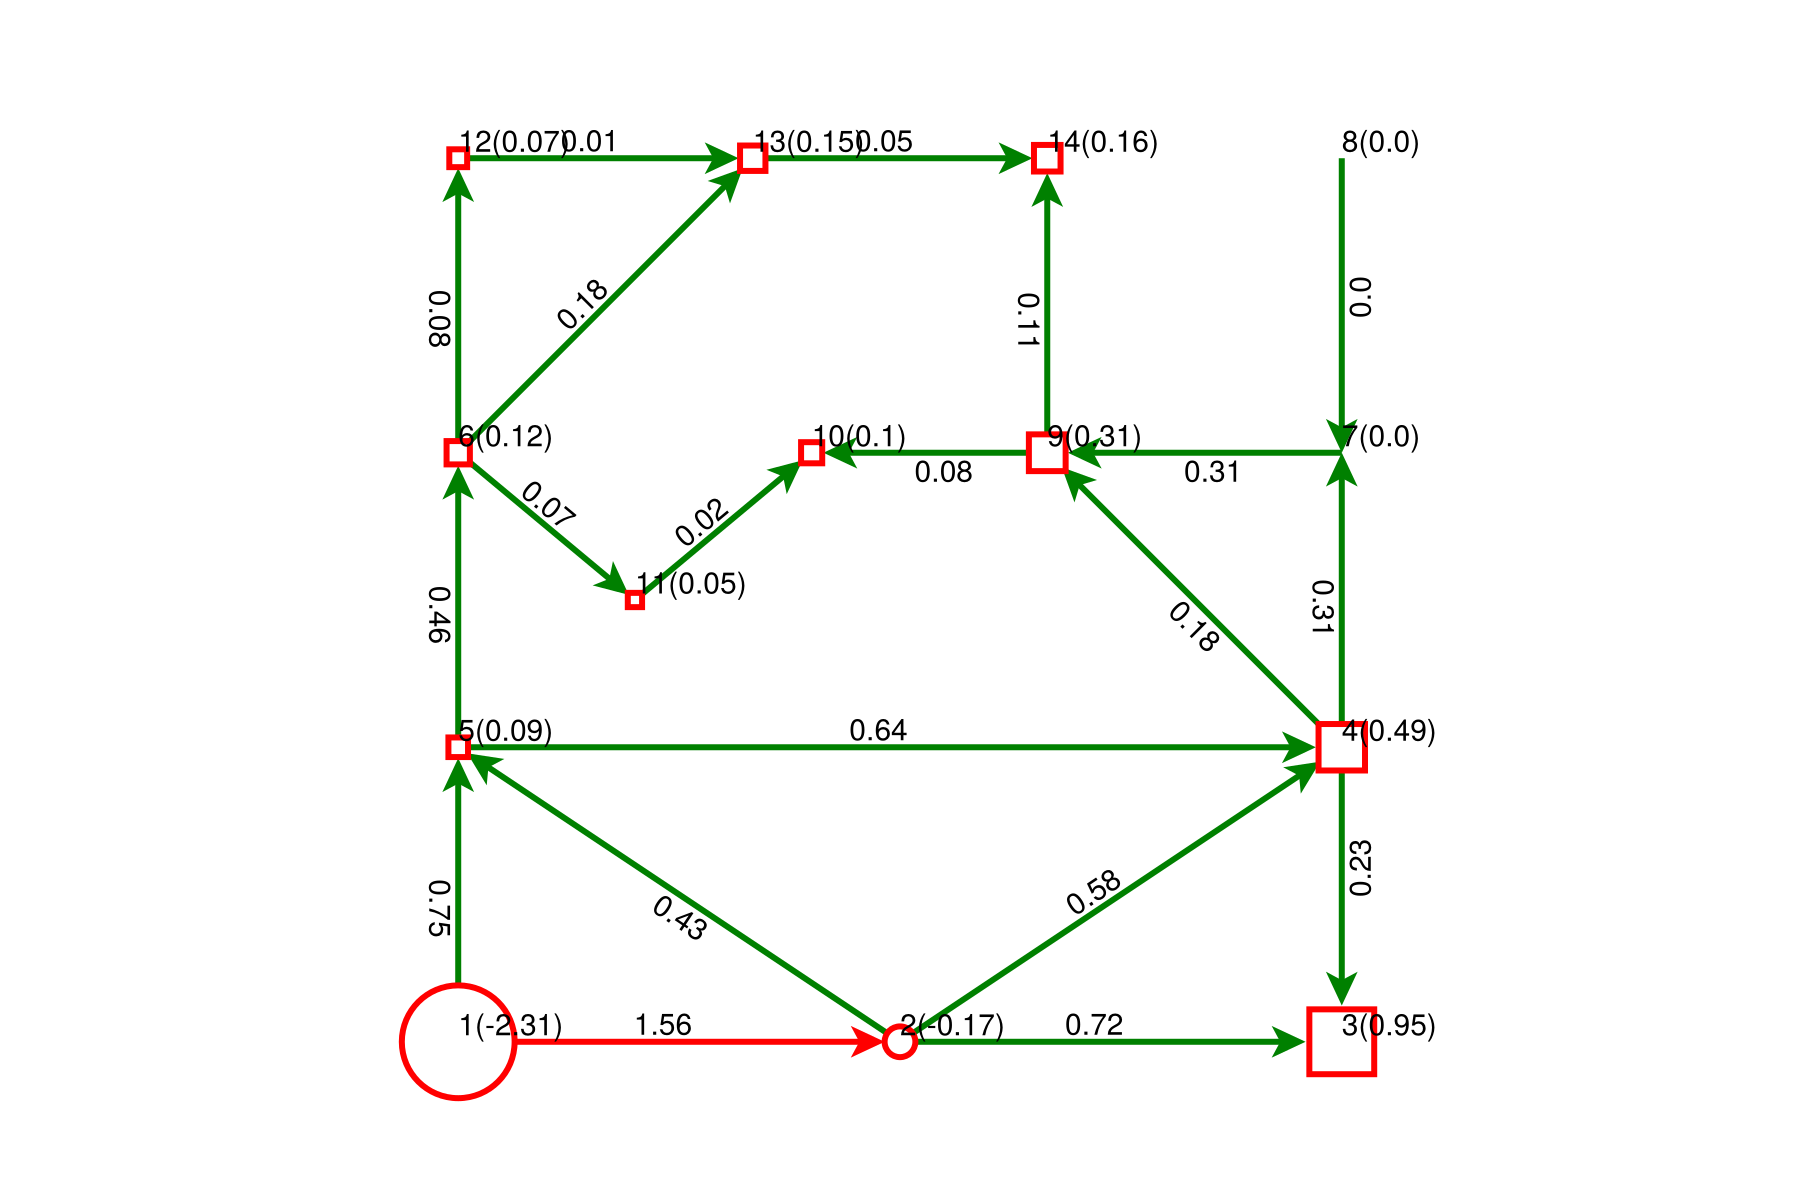

"overload: 0.9531666666666614"

"open:[2, 7, 11, 12, 16]"

5-element Vector{Tuple{String, String}}:
 ("6", "12")
 ("2", "5")
 ("9", "10")
 ("3", "4")
 ("13", "14")

"v_bus: [1.0]"

"γ_bus: [0.250481571666668;;]"

"applied_conf: BusConf[BusConf(6, SubBus[SubBus(-0.17, Int8[7, 9])])]"

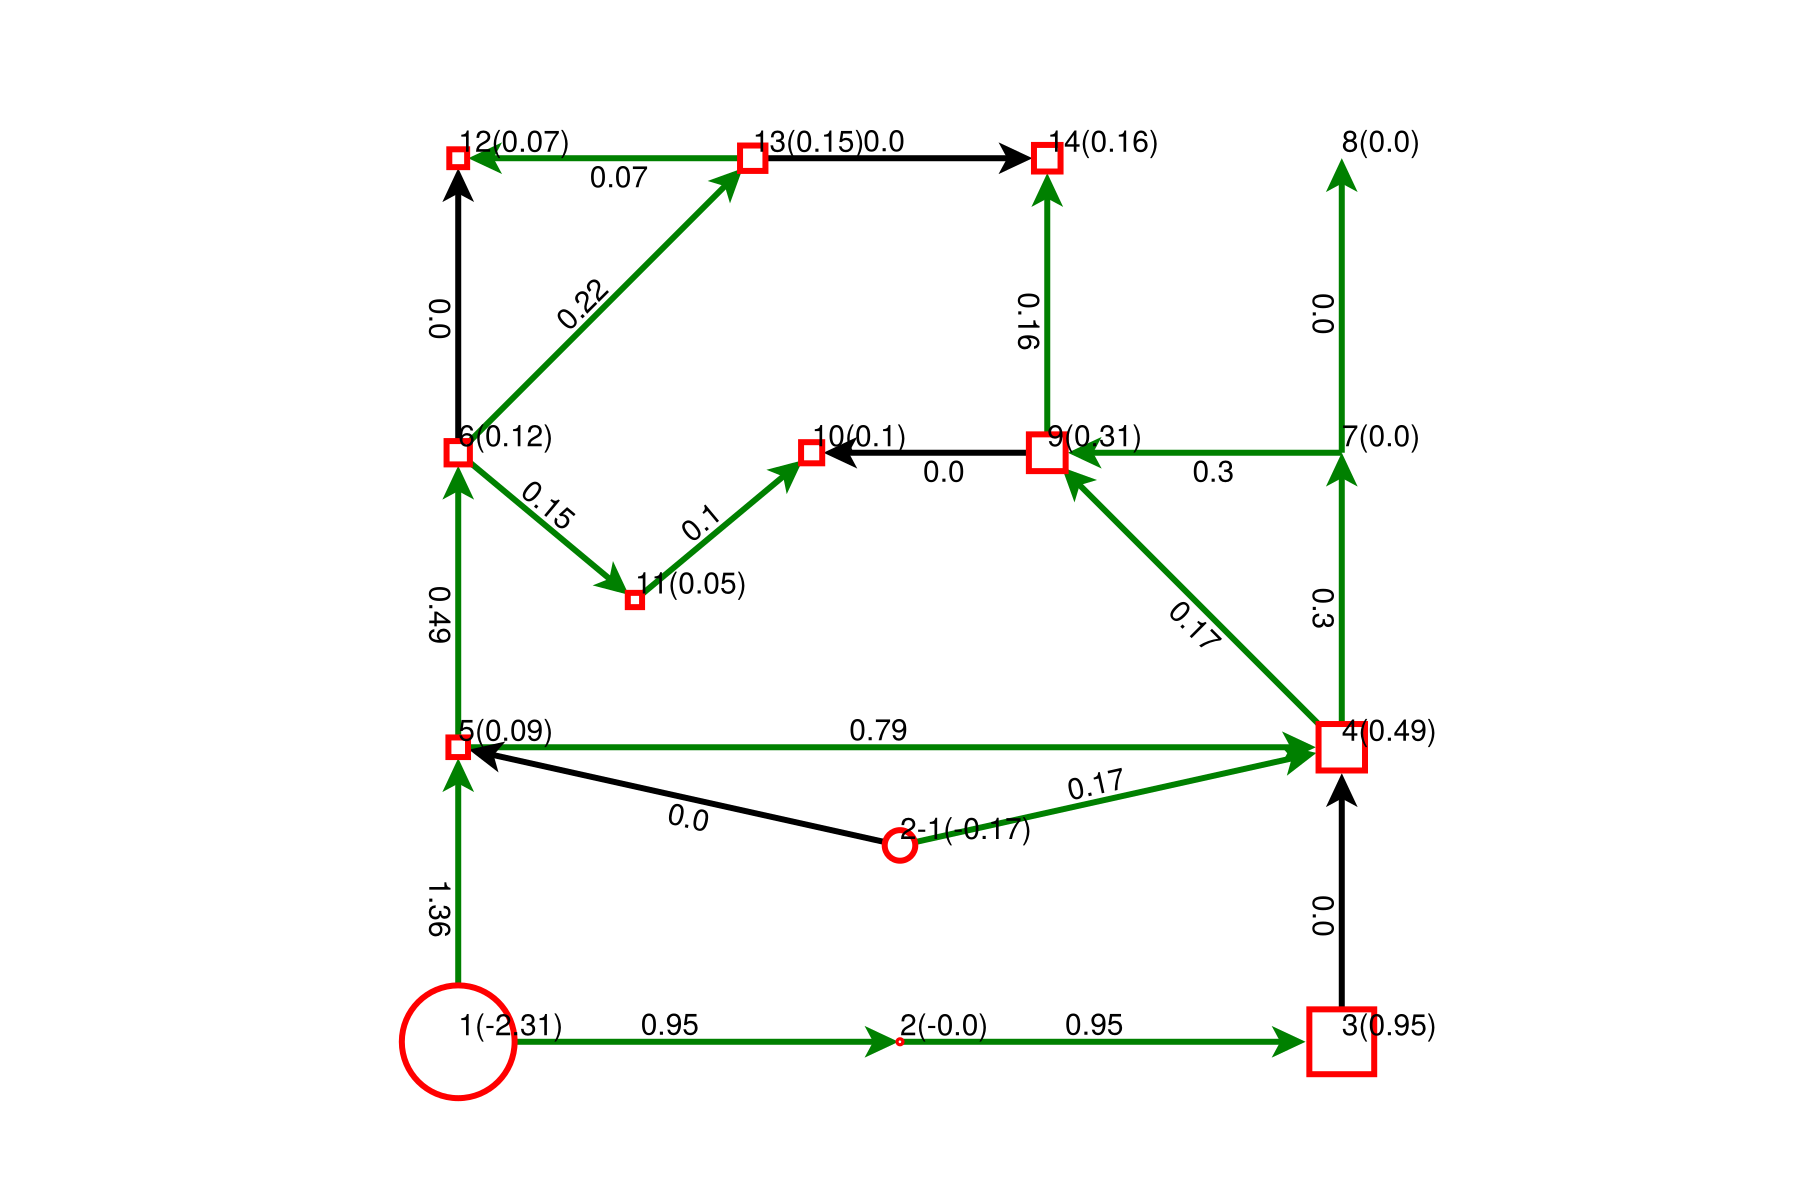

* Solver : Gurobi

* Status
  Result count       : 6
  Termination status : OPTIMAL
  Message from the solver:
  "Model was solved to optimality (subject to tolerances), and an optimal solution is available."

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 9.53167e-01
  Objective bound    : 9.53167e-01
  Relative gap       : 0.00000e+00
  Dual objective value : 9.53167e-01

* Work counters
  Solve time (sec)   : 3.34640e-02
  Barrier iterations : 0
  Node count         : 1


Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-27
Set parameter DualReductions to value 0
Set parameter LogFile to value "my_log_file.txt"
Set parameter DualReductions to value 0
Set parameter LogFile to value "my_log_file.txt"
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.1.0 23B81)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 289 rows, 132 columns and 1466 nonzeros
Model fingerprint: 0x1f615ddf
Variable types: 111 continuous, 21 integer (21 binary)
Coefficient statistics:
  Matrix range     [3e-04, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 2e+01]
Presolve removed 117 rows and 65 columns
Presolve time: 0.00s
Presolved: 172 rows, 67 columns, 666 nonzeros
Variable types: 47 continuous, 20 integer (20 binary)
Fo

In [403]:
g, bus_confs, contingencies = create_case(sys)
# g, bus_confs, contingencies, coord = create_mini_case(false)
is_single_ρ = true
ρ_min_bound = 0.
n_1_connectedness = false
allow_branch_openings = true
# bus_confs = BusConf[]

g["1","5"].p_max = 2

model = secured_dc_OTS(g,
                # contingencies = contingencies,
                # contingencies =1:20, #vcat(1:16,19:20),#,19,20],
                # contingencies = [1,2],
                is_single_ρ=is_single_ρ,
                ρ_min_bound=ρ_min_bound,
                n_1_connectedness = n_1_connectedness,
                allow_branch_openings = allow_branch_openings,
                bus_confs = bus_confs,
                )

# @constraint(model, model[:v_branch][12]==1)

optimize!(model)
trip = nothing #12
g_base = dc_flow(g, trip = trip)
layout = isa(coord, Dict{String, Point2}) ? coord : Stress(Ptype=Float32)
draw(g_base, trip = trip, layout = layout);

openings = []
applied_conf=BusConf[]

if is_solved_and_feasible(model)
    store_result(model, "store_result.csv")
    display("overload: $(value(model[:overload]))")

    if allow_branch_openings
        openings = [i for (i,v_branch) in enumerate(value.(model[:v_branch])) if v_branch == 1]
        display("open:$openings")
        display([collect(edge_labels(g))[i] for i in openings])
    end
    
    if bus_confs ≠ BusConf[]
        display("v_bus: $(value.(model[:v_bus]))")
        display("γ_bus: $(value.(model[:γ_bus]))")
        applied_conf = BusConf[bus_confs[i] for (i, v) in enumerate(value.(model[:v_bus])) if isapprox(v, 1, atol=1e-9)]
        display("applied_conf: $applied_conf")
    end
    # openings = [10]
    g_result, openings_result=add_subBus(g, applied_conf, openings)
    dc_flow!(g_result, outages = [openings_result])
    draw(g_result , outages = openings_result, layout = layout);
else
    display("NOT FEASIBLE")
end

play_openings = [1,10]
play_conf = applied_conf
g_play=add_subBus(g, play_conf)
balance!(g_play)
play_trip = 1
dc_flow!(g_play, outages = play_openings, trip = play_trip)
# draw(g_play , outages = play_openings, trip = play_trip, layout = layout);
nothing;

display(solution_summary(model))

In [235]:
collect(enumerate(edge_labels(g_result)))

20-element Vector{Tuple{Int64, Tuple{String, String}}}:
 (1, ("5", "6"))
 (2, ("6", "12"))
 (3, ("6", "11"))
 (4, ("6", "13"))
 (5, ("12", "13"))
 (6, ("10", "11"))
 (7, ("2", "3"))
 (8, ("9", "14"))
 (9, ("9", "10"))
 (10, ("3", "4"))
 (11, ("4", "5"))
 (12, ("4", "9"))
 (13, ("4", "7"))
 (14, ("13", "14"))
 (15, ("1", "5"))
 (16, ("1", "2"))
 (17, ("7", "9"))
 (18, ("7", "8"))
 (19, ("2-1", "5"))
 (20, ("2-1", "4"))

In [116]:
A1 = [1 -1 0 0;
      1 0 0 -1;
      0 1 -1 0;
      0 1 0 -1;
      0 0 1 -1]
B1 = [-2 -1 -1 0 0]'
X = A1\B1

4×1 Matrix{Float64}:
 -1.25
  0.25000000000000006
  0.7500000000000002
  0.2500000000000001

In [140]:
foreach(k->println("$k: $(value(k))"), all_variables(model))

v_branch[1]: 0.0
v_branch[2]: 0.0
v_branch[3]: 0.0
v_branch[4]: 0.0
v_branch[5]: 0.0
c_w[1,1]: 1.0
c_w[2,1]: 0.0
c_w[3,1]: 0.0
c_w[1,2]: 0.0
c_w[2,2]: 1.0
c_w[3,2]: 0.0
c_w[1,3]: 0.0
c_w[2,3]: 0.0
c_w[3,3]: 0.0
c_w[1,4]: 0.0
c_w[2,4]: 0.0
c_w[3,4]: 0.0
c_w[1,5]: 0.0
c_w[2,5]: 0.0
c_w[3,5]: 0.0
cn1_a[1]: 0.0
cn1_a[2]: 0.0
cn1_b[1]: 1.0
cn1_b[2]: 1.0
πbus[1,1]: 1.0
πbus[2,1]: 1.0
πbus[1,2]: 1.0
πbus[2,2]: 1.0
πbus[1,3]: 1.0
πbus[2,3]: 1.0
πbus[1,4]: 1.0
πbus[2,4]: 1.0
cn1_flows[1,1]: 0.0
cn1_flows[2,1]: 3.0
cn1_flows[1,2]: 3.0
cn1_flows[2,2]: 0.0
cn1_flows[1,3]: 0.0
cn1_flows[2,3]: 1.0
cn1_flows[1,4]: -1.0
cn1_flows[2,4]: 1.0
cn1_flows[1,5]: -1.0
cn1_flows[2,5]: 0.0
cn1_φ[1,1]: 4.0
cn1_φ[2,1]: 4.0
cn1_φ[1,2]: 0.0
cn1_φ[2,2]: 1.0
cn1_φ[1,3]: 0.0
cn1_φ[2,3]: 0.0
cn1_φ[1,4]: 1.0
cn1_φ[2,4]: 0.0
cn1_t_orig[1]: -3.0
cn1_t_orig[2]: -3.0
cn1_ψ[1,1,1]: 0.0
cn1_ψ[1,1,2]: 1.0
cn1_ψ[1,2,1]: 0.0
cn1_ψ[1,2,3]: 1.0
cn1_ψ[1,2,4]: 1.0
cn1_ψ[1,3,3]: 1.0
cn1_ψ[1,3,5]: 1.0
cn1_ψ[1,4,2]: 1.0
cn1_ψ[1,4,4]: 1

In [155]:
compute_conflict!(model)


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.1.0 23B81)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s

IIS computed: 10 constraints and 0 bounds
IIS runtime: 0.00 seconds (0.00 work units)


In [156]:
get_attribute(model, MOI.ConflictStatus())
iis_model, _ = copy_conflict(model)
print(iis_model)
    

┌ Warning: Model contains extension data of type Vector{Float64} that we do not know how to copy.
│ 
│ If you are using a JuMP extension and you did not add data to the `model.ext` dictionary. Please open an issue on the GitHub repository of the JuMP extension and tell them to implement `JuMP.copy_extension_data`.
│ 
│ If you added things to `model.ext`, they have not been copied.
└ @ JuMP /Users/benoitjeanson/.julia/packages/JuMP/kSaGf/src/copy.jl:20
┌ Warning: Model contains extension data of type Int64 that we do not know how to copy.
│ 
│ If you are using a JuMP extension and you did not add data to the `model.ext` dictionary. Please open an issue on the GitHub repository of the JuMP extension and tell them to implement `JuMP.copy_extension_data`.
│ 
│ If you added things to `model.ext`, they have not been copied.
└ @ JuMP /Users/benoitjeanson/.julia/packages/JuMP/kSaGf/src/copy.jl:20
┌ Warning: Model contains extension data of type Bool that we do not know how to copy.
│ 
│ If you

Feasibility
Subject to
 c_flows[1,1] + c_Φ[1,1] - c_Φ[1,2] = 0
 c_flows[1,2] + c_Φ[1,1] - c_Φ[1,4] = 0
 c_flows[1,3] + c_Φ[1,2] - c_Φ[1,3] = 0
 c_flows[1,4] + c_Φ[1,2] - c_Φ[1,4] = 0
 c_flows[1,5] + c_Φ[1,3] - c_Φ[1,4] = 0
 c_flows[1,1] + c_flows[1,2] = 3
 -c_flows[1,1] + c_flows[1,3] + c_flows[1,4] = -1
 -c_flows[1,3] + c_flows[1,5] = -1
 c_w[1,5] = 1
 4 c_w[1,5] - c_flows[1,5] ≤ 4


In [157]:
list_of_conflicting_constraints = ConstraintRef[]
for (F, S) in list_of_constraint_types(model)
    for con in all_constraints(model, F, S)
        if get_attribute(con, MOI.ConstraintConflictStatus()) == MOI.IN_CONFLICT
            push!(list_of_conflicting_constraints, con)
        end
    end
end

In [158]:
list_of_conflicting_constraints

10-element Vector{ConstraintRef}:
 c_flows[1,1] + c_Φ[1,1] - c_Φ[1,2] = 0
 c_flows[1,2] + c_Φ[1,1] - c_Φ[1,4] = 0
 c_flows[1,3] + c_Φ[1,2] - c_Φ[1,3] = 0
 c_flows[1,4] + c_Φ[1,2] - c_Φ[1,4] = 0
 c_flows[1,5] + c_Φ[1,3] - c_Φ[1,4] = 0
 c_flows[1,1] + c_flows[1,2] = 3
 -c_flows[1,1] + c_flows[1,3] + c_flows[1,4] = -1
 -c_flows[1,3] + c_flows[1,5] = -1
 c_w[1,5] = 1
 4 c_w[1,5] - c_flows[1,5] ≤ 4

In [240]:
filter_latex_formulation(model, "")

"\$\$ \\begin{aligned}\n\\min\\quad & overload + 0.1 v\\_branch_{1} + 0.1 v\\_branch_{2} + 0.1 v\\_branch_{3} + 0.1 v\\_branch_{4} + 0.1 v\\_branch_{5} + 0.1 v\\_branch_{6} + 0.1 v\\_branch_{7} + 0.1 v\\_branch_{8} + 0.1 v\\_branch_{9} + 0.1 v\\_branch_{10} + 0.1 v\\_branch_{11} + 0.1 v\\" ⋯ 49589 bytes ⋯ "ranch_{14} \\in \\{0, 1\\}\\\\\n & v\\_branch_{15} \\in \\{0, 1\\}\\\\\n & v\\_branch_{16} \\in \\{0, 1\\}\\\\\n & v\\_branch_{17} \\in \\{0, 1\\}\\\\\n & v\\_branch_{18} \\in \\{0, 1\\}\\\\\n & v\\_branch_{19} \\in \\{0, 1\\}\\\\\n & v\\_branch_{20} \\in \\{0, 1\\}\\\\\n & v\\_bus_{1} \\in \\{0, 1\\}\\\\\n\\end{aligned} \$\$"

In [40]:
A = [[1, 0] [-1, 1] [ 0, -1]]
# A = [[1, 0] [-1, 0] [ 0, 0]]
B = A'*A
Binv = inv(B + fill(1/3,3,3))
display(inv(B + fill(1/30,3,3)))
display(Binv)
display(Binv - fill(1/3,3,3))
# A*Binv*[1, -1, 1]
# A*Binv
# B = A'*A + fill(1/3, 3, 3)
# inv(B)


3×3 Matrix{Float64}:
 3.88889  3.22222  2.88889
 3.22222  3.55556  3.22222
 2.88889  3.22222  3.88889

3×3 Matrix{Float64}:
  0.888889  0.222222  -0.111111
  0.222222  0.555556   0.222222
 -0.111111  0.222222   0.888889

3×3 Matrix{Float64}:
  0.555556  -0.111111  -0.444444
 -0.111111   0.222222  -0.111111
 -0.444444  -0.111111   0.555556

In [41]:
A = [1 -1]
B = A'*A
Binv = inv(B + fill(1/2, 2, 2))
display(inv(B + fill(1/20, 2, 2)))
display(Binv)
display(Binv - fill(1/2, 2, 2))


2×2 Matrix{Float64}:
 5.25  4.75
 4.75  5.25

2×2 Matrix{Float64}:
 0.75  0.25
 0.25  0.75

2×2 Matrix{Float64}:
  0.25  -0.25
 -0.25   0.25